Notebook dependencies: 
- sampling (dev)
- Visualization: plotly, seaborn, matplotlib
- Data processing: numpy, pandas


TODO
- [ ] Convergence plots
- [ ] Smooth vs Variance of estimates vs Time to run

In [1]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Data processing
import pandas as pd
import numpy as np

# Time
from time import time

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ----------------------------------------------------------------
# Default theme configurations
# ----------------------------------------------------------------
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
matplotlib.rcParams.update({'errorbar.capsize': 4})

# Set default theme for seaborn plots
sns.set_style("whitegrid")
DEFAULT_PALETTE = sns.color_palette("tab10", n_colors=1)

# ----------------------------------------------------------------
# Visualizations
# ----------------------------------------------------------------
def barplot(values, stds, palette=DEFAULT_PALETTE, **kwargs):
    default_args = {"ecolor": "black", "alpha": 1}
    if kwargs:
        default_args.update(kwargs)
        
    n = len(values)
    index = np.arange(n)
    
    return sns.barplot(x=index, y=values, yerr=stds, palette=palette, **default_args)


def barplot_ncol(values, stds, titles, palette=DEFAULT_PALETTE, figsize=(10, 5), tick_freq=5, **kwargs):
    n = len(values)
    
    fig, axes = plt.subplots(1, n, sharey=True, figsize=figsize)
    
    for i in range(n):
        barplot(values[i], stds[i], ax=axes[i], palette=DEFAULT_PALETTE, **kwargs)
        axes[i].set_title(titles[i])
        axes[i].set_xticks(np.arange(len(values[i]))[::tick_freq])
    plt.show()
    
    
def sample_mean_std(array, stepsize=5):
    """Computes how the values converge to a mean and its std"""
    means, cis, ids = [], [], []
    
    for i in range(stepsize, len(array), stepsize):
        mean = array[:i].mean().item()
        means.append(mean)
        
        std = array[:i].std().item() / np.sqrt(i)
        cis.append((mean-std, mean+std)) 
        ids.append(i)
    else:
        mean = array.mean().item()
        means.append(mean)
        std = array.std().item() / np.sqrt(i)
        cis.append((mean-std, mean+std))
        ids.append(len(array))
        
    return means, cis, ids


def plot_convergence_plots(ids, means, cis, labels, input_str, avoid_terms, figsize=(10,5)):
    plt.figure(figsize=figsize)
    
    for i in range(len(ids)):
        ax = sns.lineplot(x=ids[i], y=means[i], label=labels[i])
        ax.fill_between(ids[i], *zip(*cis[i]), alpha=0.5)

    plt.title(f"$P(N_A(K) = 0 |\, H=$'{input_str}'$)$, where $A =$" + "{" + avoid_terms +"}")
    plt.show()

## Setup

In [2]:
from sampling.importance_sampler import ImportanceSampler
from sampling.naive_sampler import NaiveSampler

MODEL_NAME = "EleutherAI/gpt-neo-125M"

# Load the sampler (including model + tokenizer)
sampler_is = ImportanceSampler(MODEL_NAME, device="cuda")
sampler_mc = NaiveSampler(MODEL_NAME, device="cuda")

Importing classes for model EleutherAI/gpt-neo-125M
 -> <class 'transformers.models.gpt2.tokenization_gpt2.GPT2Tokenizer'>
 -> <class 'transformers.models.gpt_neo.modeling_gpt_neo.GPTNeoForCausalLM'>
Vocabulary size: 50257
Pad token id: 50256
Importing classes for model EleutherAI/gpt-neo-125M
 -> <class 'transformers.models.gpt2.tokenization_gpt2.GPT2Tokenizer'>
 -> <class 'transformers.models.gpt_neo.modeling_gpt_neo.GPTNeoForCausalLM'>
Vocabulary size: 50257
Pad token id: 50256


## sample_not_occur

In [3]:
NUM_SEQUENCES = 5120

estimate_not_occur_kwargs = {
    # "input_str": "Hello! My name is",
    "input_str": "He is such a",
    "avoid_terms": ". . , ! ?",
    "num_sequences": NUM_SEQUENCES,
    "batch_size": 128, # 40 iterations
    "max_num_tokens": 50,
    "seed": 97163,
}

results_mc = sampler_mc.batch_estimate_not_occurring(**estimate_not_occur_kwargs) # FIXME; ERROR if NUM_SEQ % BATCH_SIZE != 0
results_is = sampler_is.batch_estimate_not_occurring(**estimate_not_occur_kwargs)

40it [00:24,  1.60it/s]
40it [00:24,  1.66it/s]


#### convergence of the algorithm

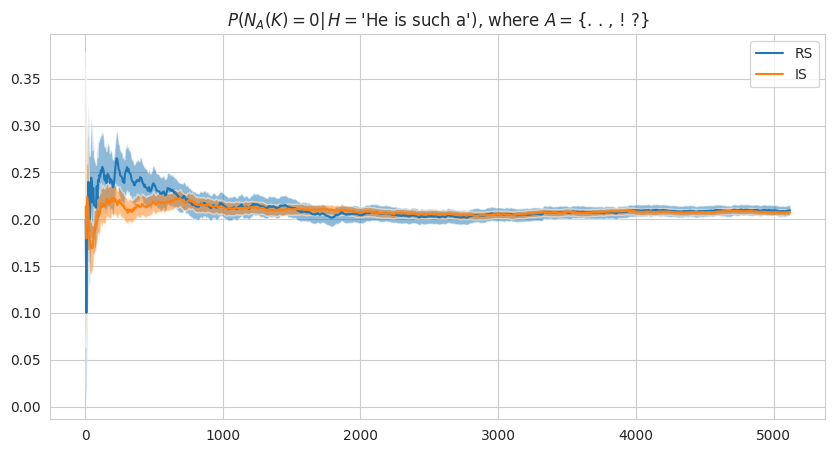

In [4]:
# TODO: Ask ALEX about unbiasedness of cumulative/token wise probabilities.
#
## convergence of the algorithm as a function of the number of samples
prob_of_occurring_at_least_once_IS = results_is.probs[-1]
prob_of_occurring_at_least_once_MC = results_mc.probs[-1]


naive_mean, naive_cis, naive_ids = sample_mean_std(prob_of_occurring_at_least_once_MC)
imp_mean, imp_cis, imp_ids = sample_mean_std(prob_of_occurring_at_least_once_IS)

plot_convergence_plots(
    ids=[naive_ids, imp_ids],
    means=[naive_mean, imp_mean],
    cis=[naive_cis, imp_cis],
    labels=["RS", "IS"],
    input_str=estimate_not_occur_kwargs["input_str"],
    avoid_terms=estimate_not_occur_kwargs["avoid_terms"],
)

#### compute confidence interval per timestep

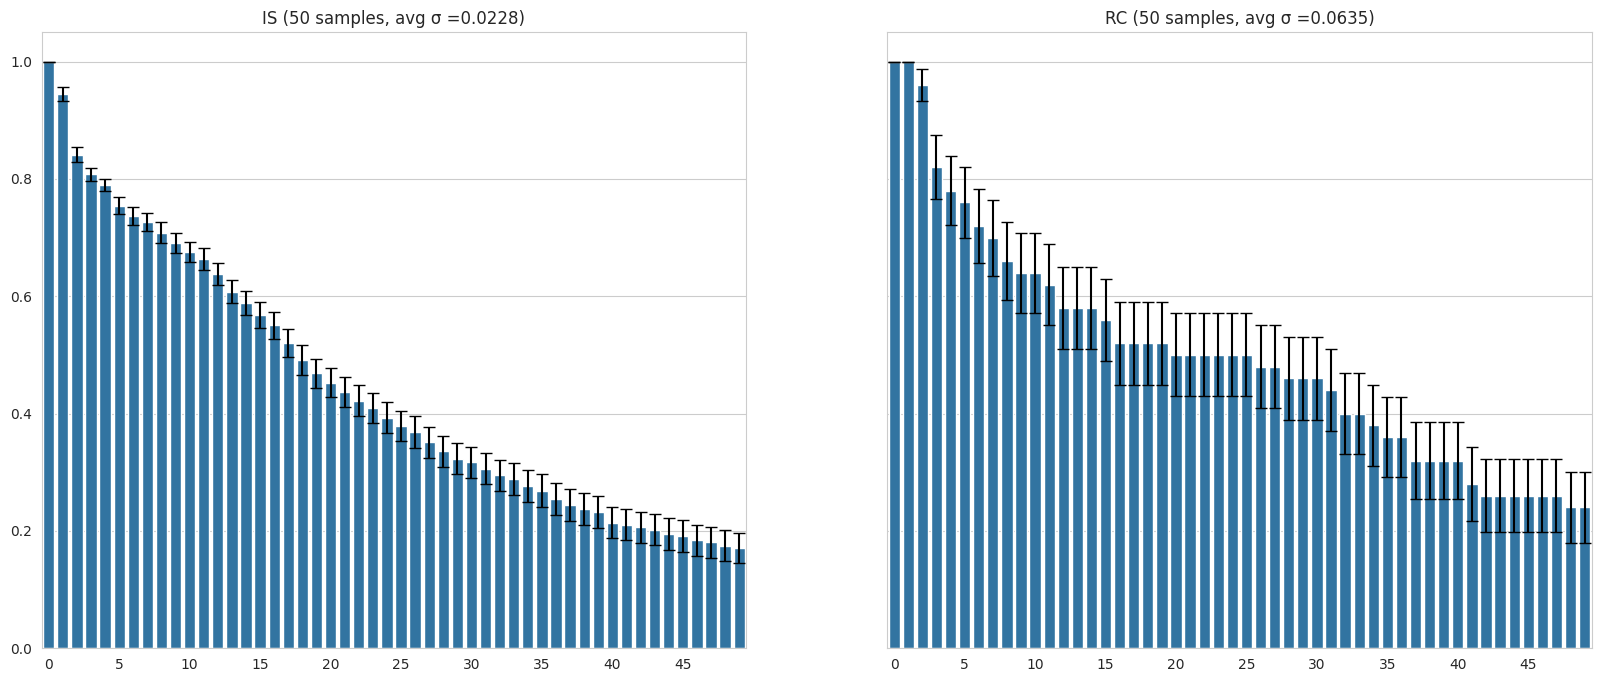

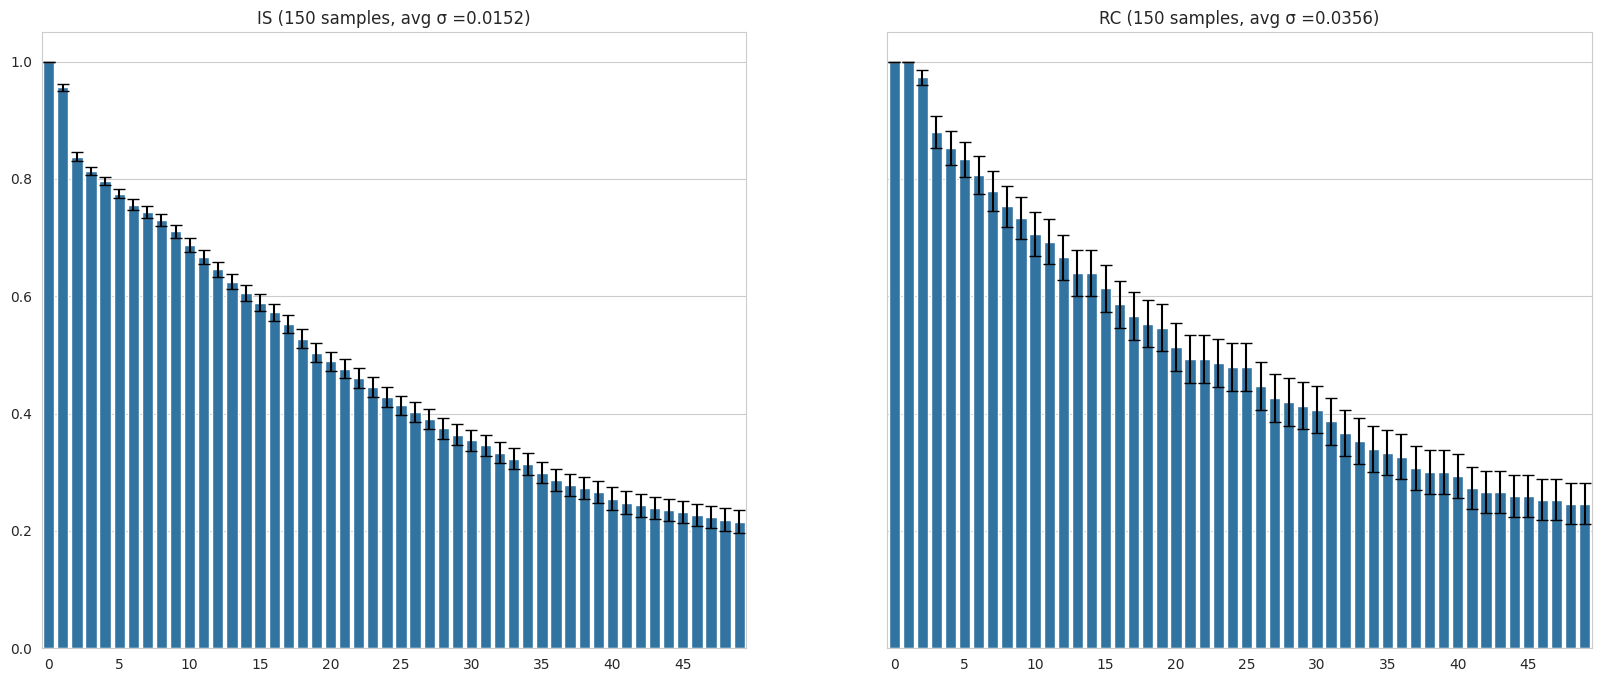

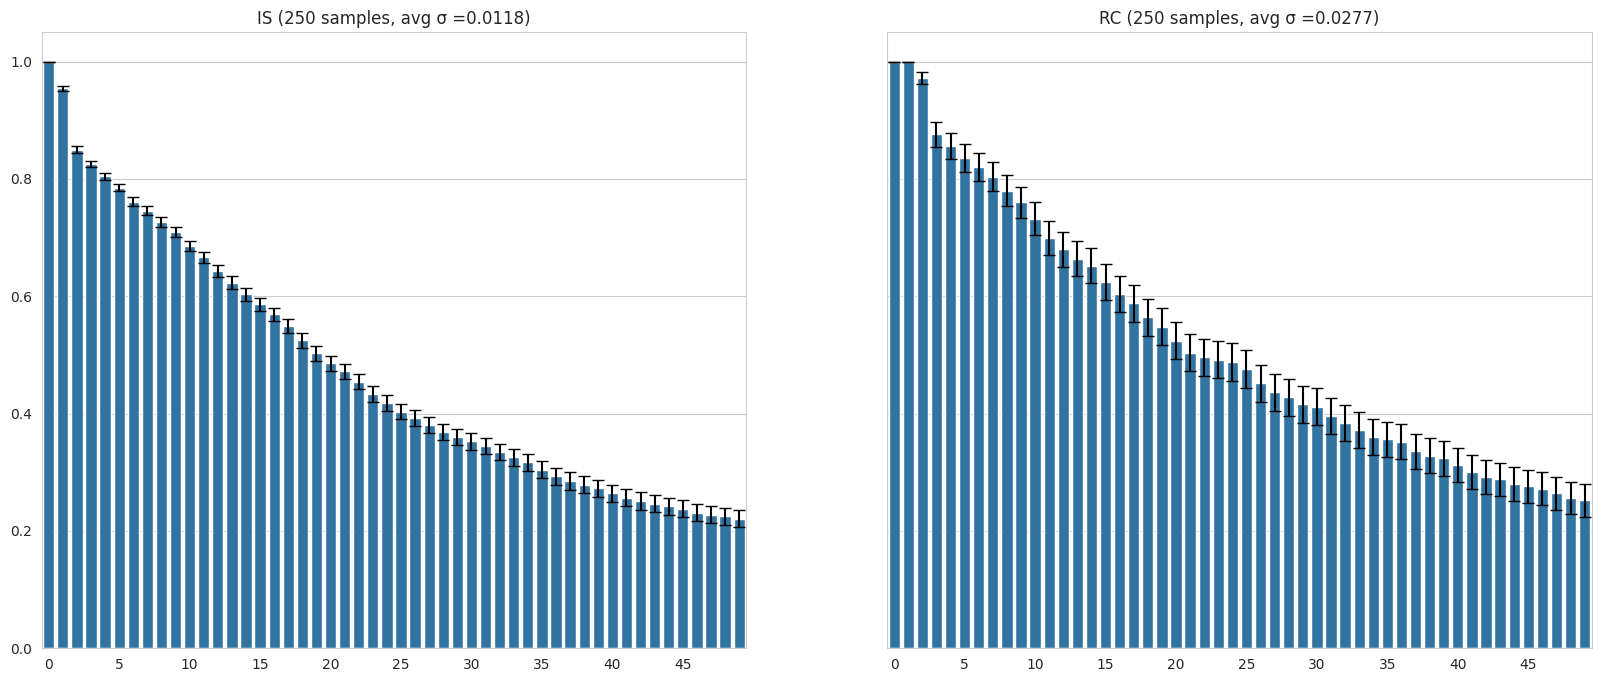

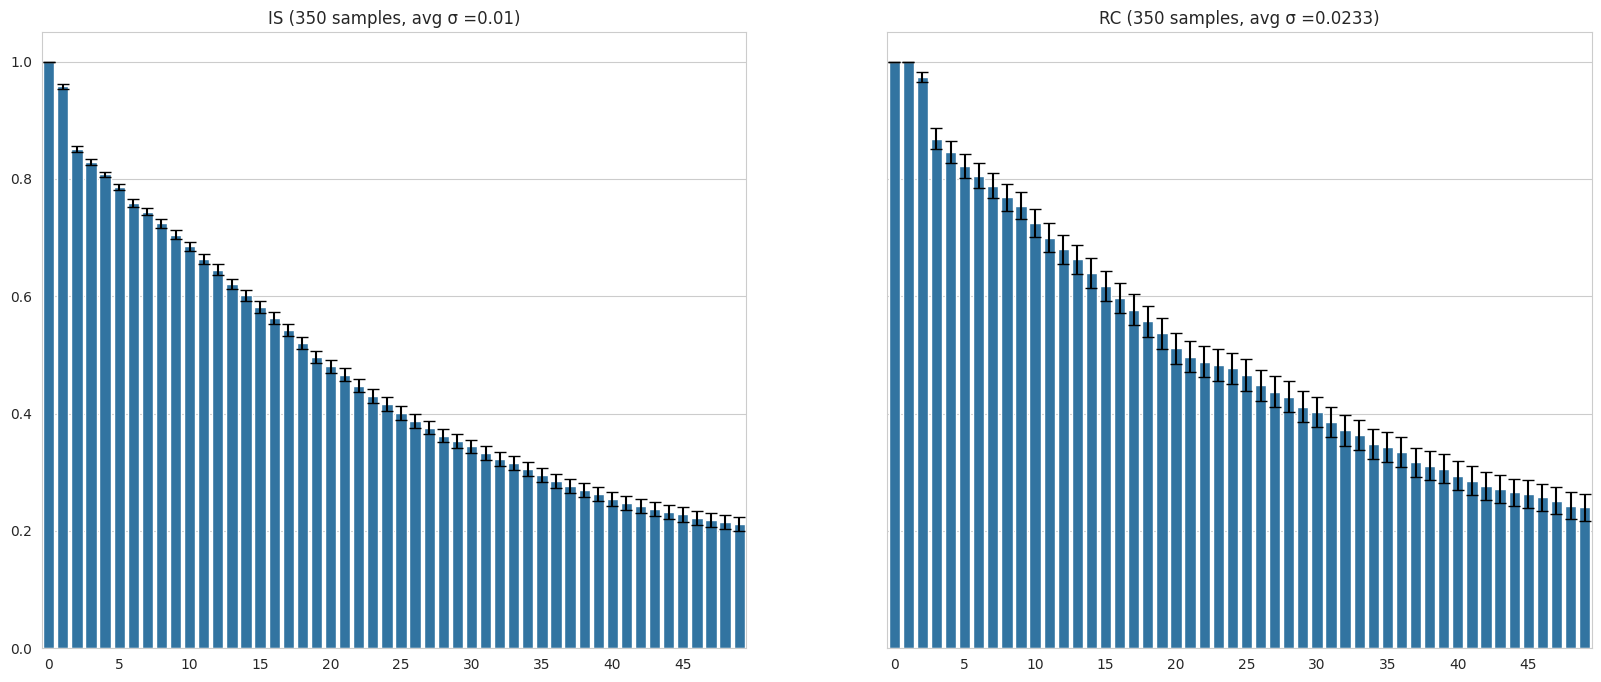

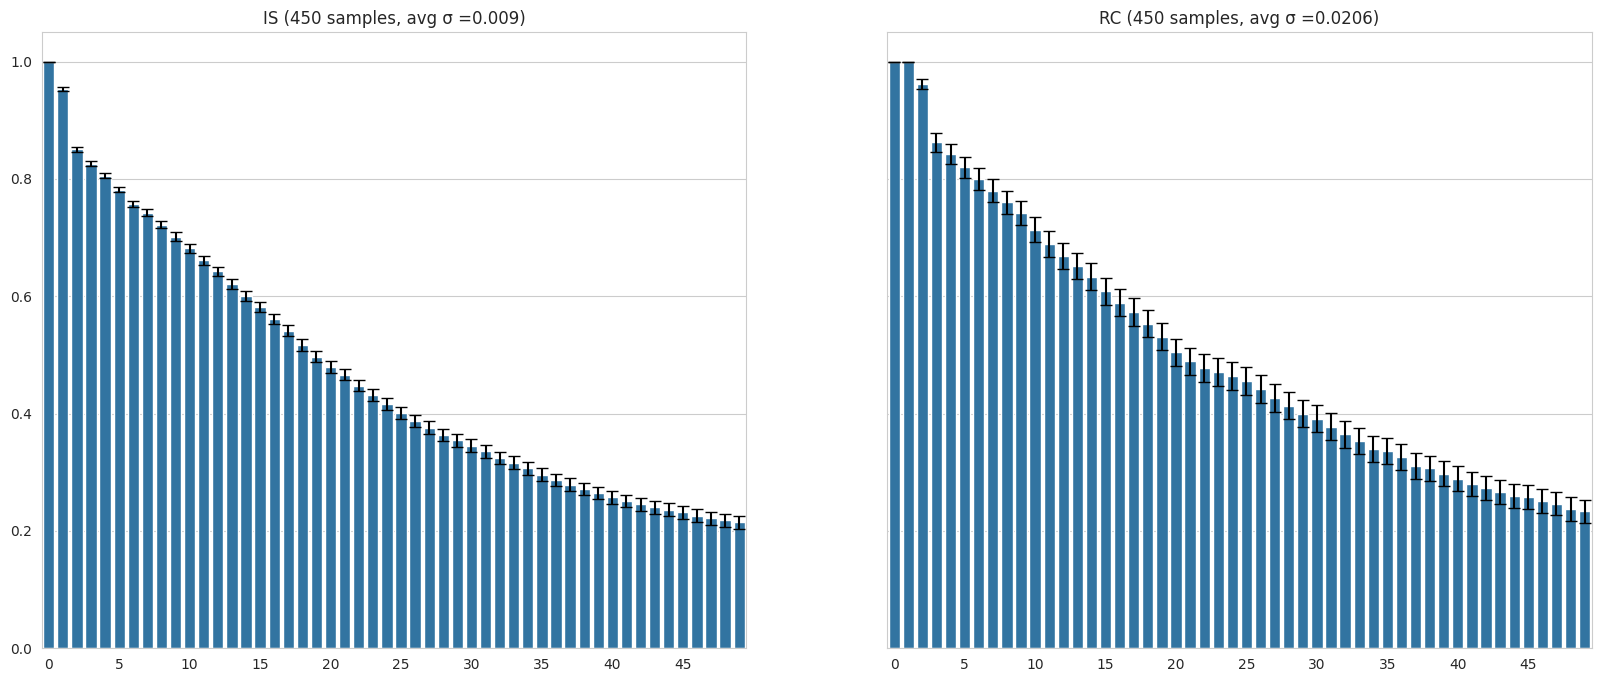

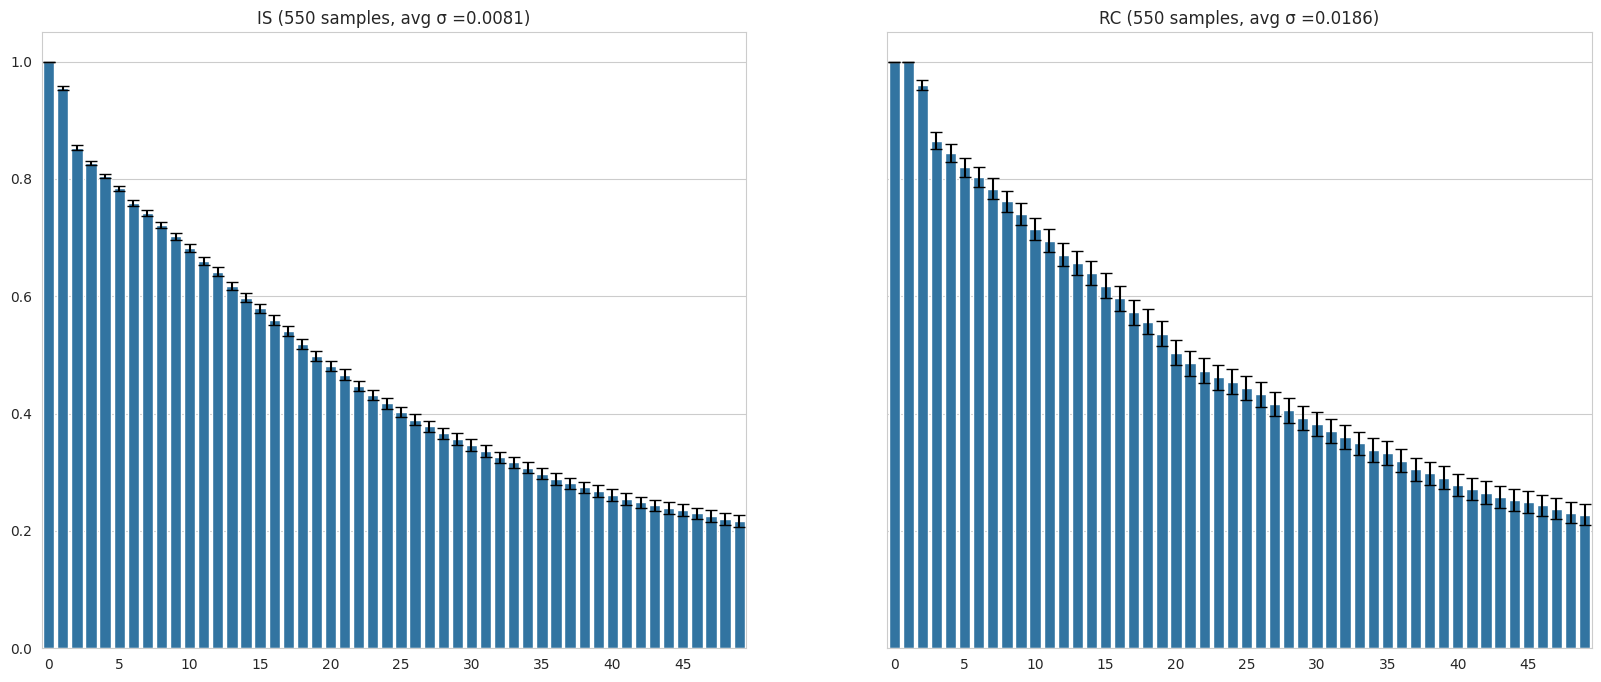

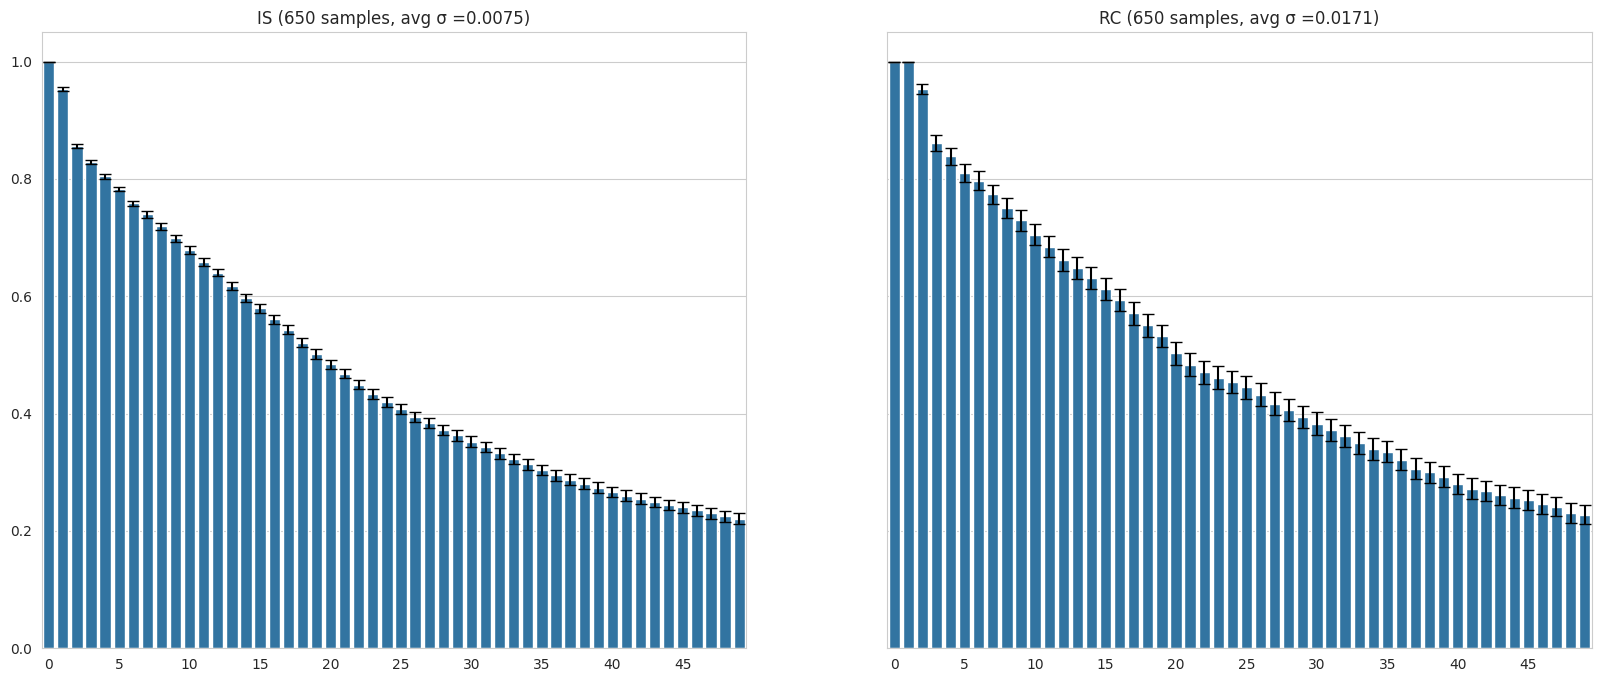

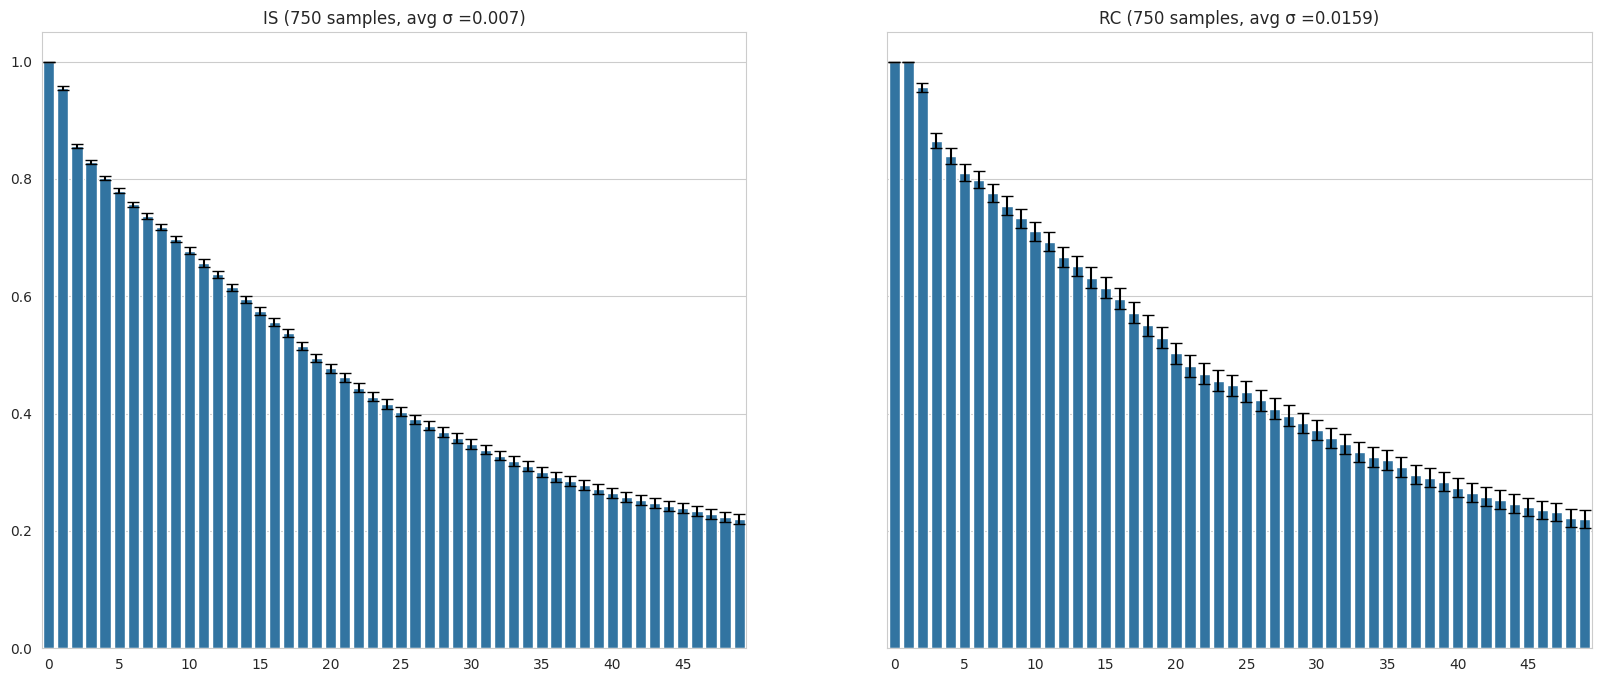

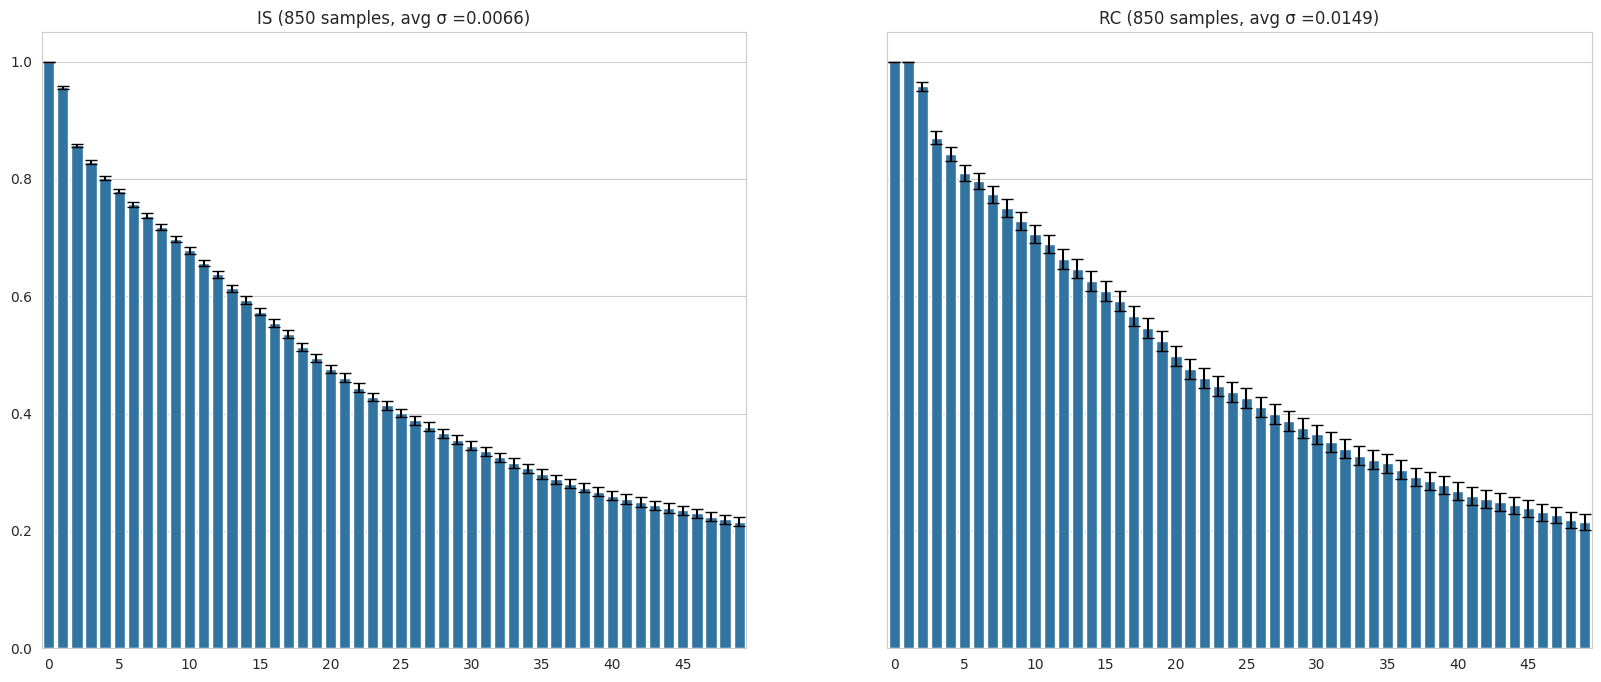

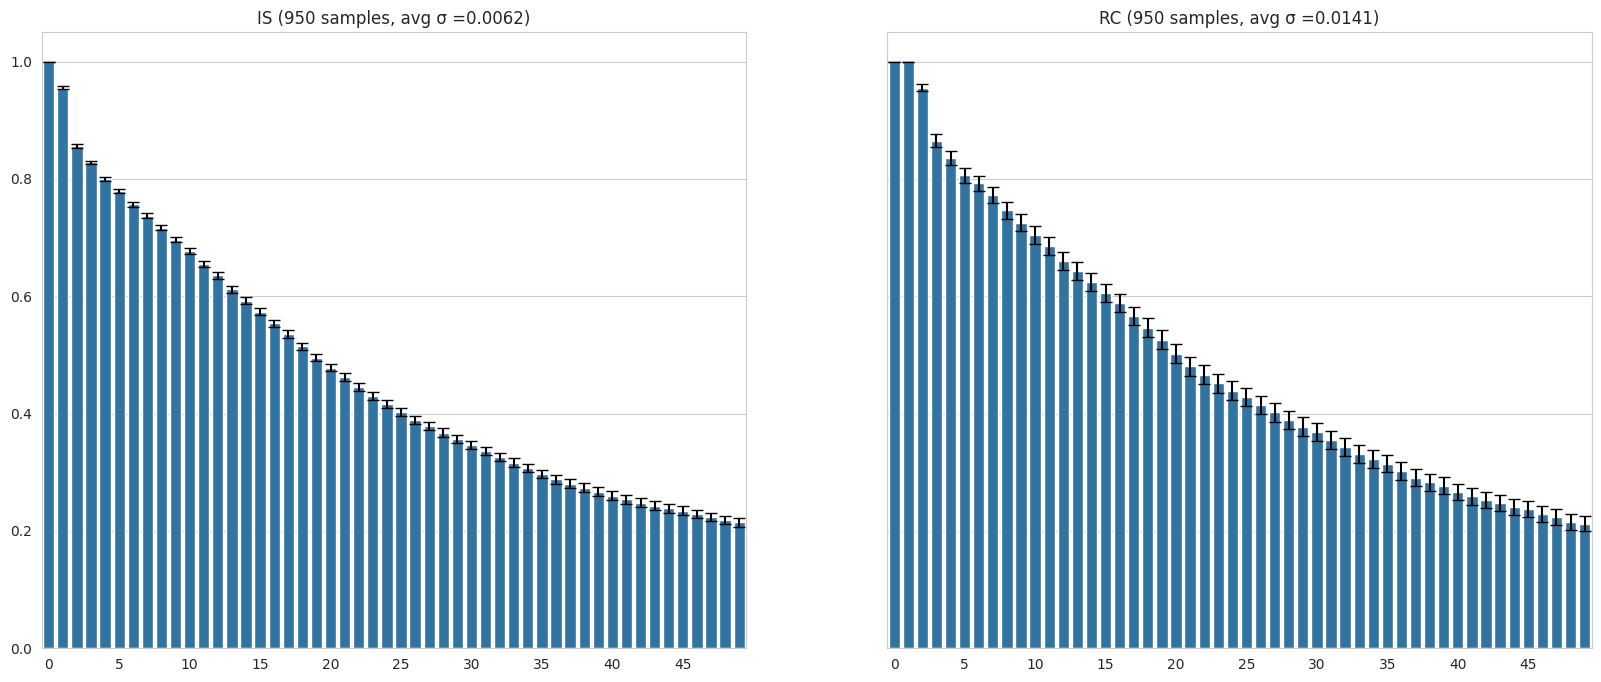

In [5]:
for i in range(50, 1000, 100):
    is_probs = [p[:i,:] for p in results_is.probs]
    mc_probs = [p[:i,:] for p in results_mc.probs]

    is_mean, is_std = sampler_is.compute_confidence_intervals(is_probs, width=1)
    mc_mean, mc_std = sampler_mc.compute_confidence_intervals(mc_probs, width=1)
    
    
    
    barplot_ncol(
        values=[is_mean, mc_mean],
        stds=[is_std, mc_std],
        titles=[f"IS ({i} samples, avg σ ={round(np.mean(is_std), 4)})", f"RC ({i} samples, avg σ ={round(np.mean(mc_std), 4)})"],
        figsize=(20, 8)
    )

In [ ]:
plot how rapidly std falls

## sample_marginals

In [6]:
NUM_SEQUENCES = 5120

estimate_marginals_kwargs = {
    "input_str": "He is such a",
    "terms": ". . , ! ?",
    "num_sequences": NUM_SEQUENCES,
    "batch_size": 128, # 40 iterations
    "max_num_tokens": 50,
    "seed": 97163,
}

marginals_results_mc = sampler_mc.batch_estimate_marginals(sampling_out=results_mc, **estimate_marginals_kwargs)

0it [00:00, ?it/s]


AxisError: axis 1 is out of bounds for array of dimension 1

In [7]:
results_is = sampler_is.batch_estimate_marginals(**estimate_not_occur_kwargs)

TypeError: BaseSampler.batch_estimate_marginals() missing 1 required positional argument: 'terms'

## hit_probability